In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from torchinfo import summary

from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.utils import *
from ignite.contrib.metrics.regression import *
from ignite.contrib.metrics import *

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
path = "./Dataset/"
mmscaler = MinMaxScaler(feature_range=(-1, 1), copy=True)

#training set
train_ax = mmscaler.fit_transform(np.loadtxt(path + "train/Inertial Signals/total_acc_x_train.txt"))
train_ay = mmscaler.fit_transform(np.loadtxt(path + "train/Inertial Signals/total_acc_y_train.txt"))
train_az = mmscaler.fit_transform(np.loadtxt(path + "train/Inertial Signals/total_acc_z_train.txt"))

train_t = np.loadtxt(path + "train/y_train.txt").astype(int) - 1
train_s = np.loadtxt(path + "train/subject_train.txt").astype(int)

#test set
test_ax = mmscaler.fit_transform(np.loadtxt(path + "test/Inertial Signals/total_acc_x_test.txt"))
test_ay = mmscaler.fit_transform(np.loadtxt(path + "test/Inertial Signals/total_acc_y_test.txt"))
test_az = mmscaler.fit_transform(np.loadtxt(path + "test/Inertial Signals/total_acc_z_test.txt"))

test_t = np.loadtxt(path + "test/y_test.txt").astype(int) - 1
test_s = np.loadtxt(path + "test/subject_test.txt").astype(int)

print(train_ax.shape)

(7352, 128)


In [3]:
train_size = 7352
test_size = 2947
dim_size = 3
sample_size = 128

In [4]:
# trX = (7352, 128, 3) ... trainのX
trX = np.ones((train_size, sample_size, dim_size), float)
print('trX.shape initial:{0}'.format(trX.shape))
for i in range(train_size):
  trX[i,:,0] = train_ax[i,:]
  trX[i,:,1] = train_ay[i,:]
  trX[i,:,2] = train_az[i,:]
print('trX.shape assigned:{0}'.format(trX.shape))

trY = train_t

# teX = (2947, 3, 128) ... testのX
teX = np.ones((test_size, sample_size, dim_size), float)
print('trX.shape initial:{0}'.format(trX.shape))
for i in range(test_size):
  teX[i,:,0] = test_ax[i,:]
  teX[i,:,1] = test_ay[i,:]
  teX[i,:,2] = test_az[i,:]
print('trX.shape assigned:{0}'.format(trX.shape))

teY = test_t

trX.shape initial:(7352, 128, 3)
trX.shape assigned:(7352, 128, 3)
trX.shape initial:(7352, 128, 3)
trX.shape assigned:(7352, 128, 3)


In [5]:
# datax = np.vstack([trX, teX])
# print('datax.shape:{0}'.format(datax.shape))
# datay = np.vstack([trY, teY])
# print('datay.shape:{0}'.format(datay.shape))
# # dataX = trX and teX (10299, 3, 128)
# dataX = torch.Tensor(np.array(datax)).to(device)
# # dataY = trY and teY (10299,1)
# dataY = torch.Tensor(np.array(datay)).to(device)

trainX = torch.Tensor(np.array(trX)).to(device)
trainY = torch.Tensor(np.array(trY)).to(device)

testX = torch.Tensor(np.array(teX)).to(device)
testY = torch.Tensor(np.array(teY)).to(device)
print(trainY.shape)
# plt.plot(train_ax[0])
# plt.plot(trX[0,:,0])
# plt.show
print(trainY.shape)
print(torch.min(trainY), torch.max(trainY))

# trainYをone-hotにするためlongにして1次元配列に戻す　-> min~maxを0~5に直す
trainY = trainY.long()
# one-hotにする -> 誤差を計算できるようにfloatに直す
trainY = F.one_hot(trainY, num_classes=-1)
trY = trainY.cpu().data.numpy().astype(float)

print(trY)

torch.Size([7352])
torch.Size([7352])
tensor(0., device='cuda:0') tensor(5., device='cuda:0')
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


In [6]:
class DataSet:
    def __init__(self):
        self.X = trX
        self.t = trY

    def __len__(self):
        return len(self.X) # データ数(10)を返す

    def __getitem__(self, index):
        # index番目の入出力ペアを返す
        return self.X[index], self.t[index]

dataset = DataSet()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

In [7]:
class MyLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_size_1 = 50
        self.hidden_size_2 = 70
        self.lstm_1 = nn.LSTM(input_size=3, hidden_size=self.hidden_size_1, num_layers=1, batch_first=True) 
        self.lstm_2 = nn.LSTM(input_size=self.hidden_size_1, hidden_size=self.hidden_size_2, num_layers=1, batch_first=True) 
        self.relu = nn.ReLU()
        self.linear = nn.Linear(70, 6)
        #self.softmax = nn.Softmax(-1)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_size_1).to(device)
        c_0 = torch.zeros(1, x.size(0), self.hidden_size_1).to(device)
        h_1 = torch.zeros(1, x.size(0), self.hidden_size_2).to(device)
        c_1 = torch.zeros(1, x.size(0), self.hidden_size_2).to(device)
        out, (h_out, c_out) = self.lstm_1(x, (h_0, c_0))
        _, (h_out, _) = self.lstm_2(out, (h_1, c_1))
        h_out = h_out.view(-1, self.hidden_size_2)
        h_out = self.relu(h_out)
        y_hat = self.linear(h_out)
        #y_hat = self.softmax(h_out)
        return y_hat



# print(summary(MyLSTM(), input_size=(7352, 128, 3), device=torch.device(device)))  

In [8]:
def train(model, optimizer, data, t):
  model.train()
  y_hat = model(data)
  # loss = F.mse_loss(y_hat, t)
  loss = nn.CrossEntropyLoss()
  output = loss(y_hat, t)
  optimizer.zero_grad()
  output.backward()
  optimizer.step()
  return output.item()

loss = []

def main():
  model = MyLSTM()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
  model = model.to(device)

  for epoch in range(200):
    for data, t in dataloader:
      _loss = train(model, optimizer, data.to(device), t.to(device))
      loss.append(_loss)
    if epoch % 20 == 0:
      print(f"Epoch = {epoch+1}, Loss = {_loss:.5f}")
  return model

In [9]:
model = main()

RuntimeError: Input and hidden tensors are not the same dtype, found input tensor with Double and hidden tensor with Float

<function matplotlib.pyplot.show(close=None, block=None)>

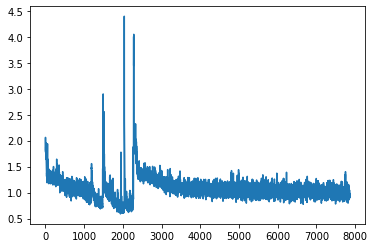

In [ ]:
plt.plot(loss)
plt.show

In [ ]:
def predict(model):
  model.eval()
  train_predict = model(testX)

  # data_predict = train_predict.cpu().data.numpy()
  # testY_plot = testY.cpu().data.numpy()

  
  data_predict = torch.argmax(train_predict, dim=-1)
  data_predict = F.one_hot(data_predict, num_classes=-1)
  
  metric = ConfusionMatrix(num_classes=6)
  metric.attach(default_evaluator, 'cm')
  y_true = testY.view(-1).int()
  y_pred = data_predict
  print(y_true.shape)
  print(y_pred.shape)

  state = default_evaluator.run([[y_pred, y_true]])
  print(state.metrics['cm'])


In [ ]:
predict(model)

torch.Size([2947])
torch.Size([2947, 6])
tensor([[126, 133,  29,  46, 160,   2],
        [ 85, 271,  10,  21,  83,   1],
        [ 84, 181,  30,  42,  78,   5],
        [ 62,   1,  15, 109, 304,   0],
        [ 71,  14,   0,  68, 379,   0],
        [  0,   0,   0,   0,   0, 537]])
